## Retrieval

Important at `query` time , based on query you'd want to retrieve relevant splits.


## Maximal marginal relevance

- You may not always want to choose most similar response.
- We may miss out on diverse information.

MMR Algorithm:
- Send a query to vector store.
- Choose `fetch_k` most similar responses
- Within those responses chosse the `k` most diverse


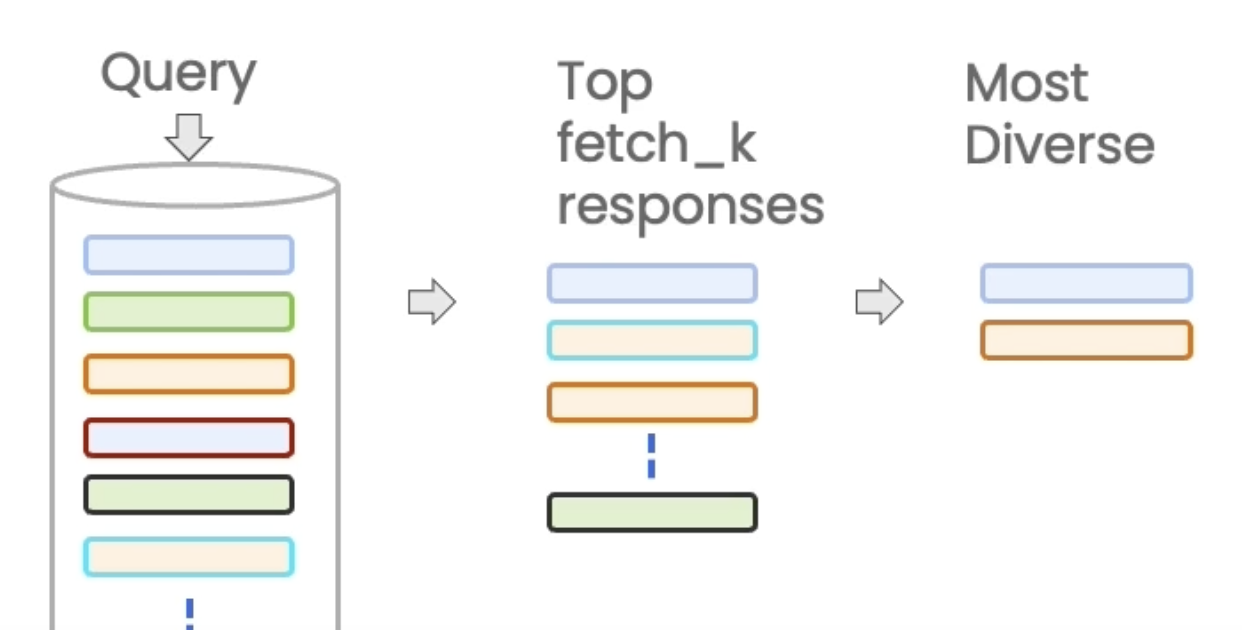

### LLM AIDED Retreival

- Situations where the `Query` applied to vectorDB is more than just the `Question` asked.
- One is SelfQuery , where we use LLM to convert the user Question into a query.

**Question** : What are some movies about aliens in 1980 ?

here **filter** : ("year,1980) , search_term : Aliens

We can use LLM itself as a query parser the extract filter and search_term

### Compression:

Only put out only most relevant data.

In basic semantic search , when asked a question , whole document is returned , even if few lines match

With Compression , we provide the semantic searched documents to language model and extract the most relevant bits of document(s).

**Cost** : more calls to API , but improves final responses

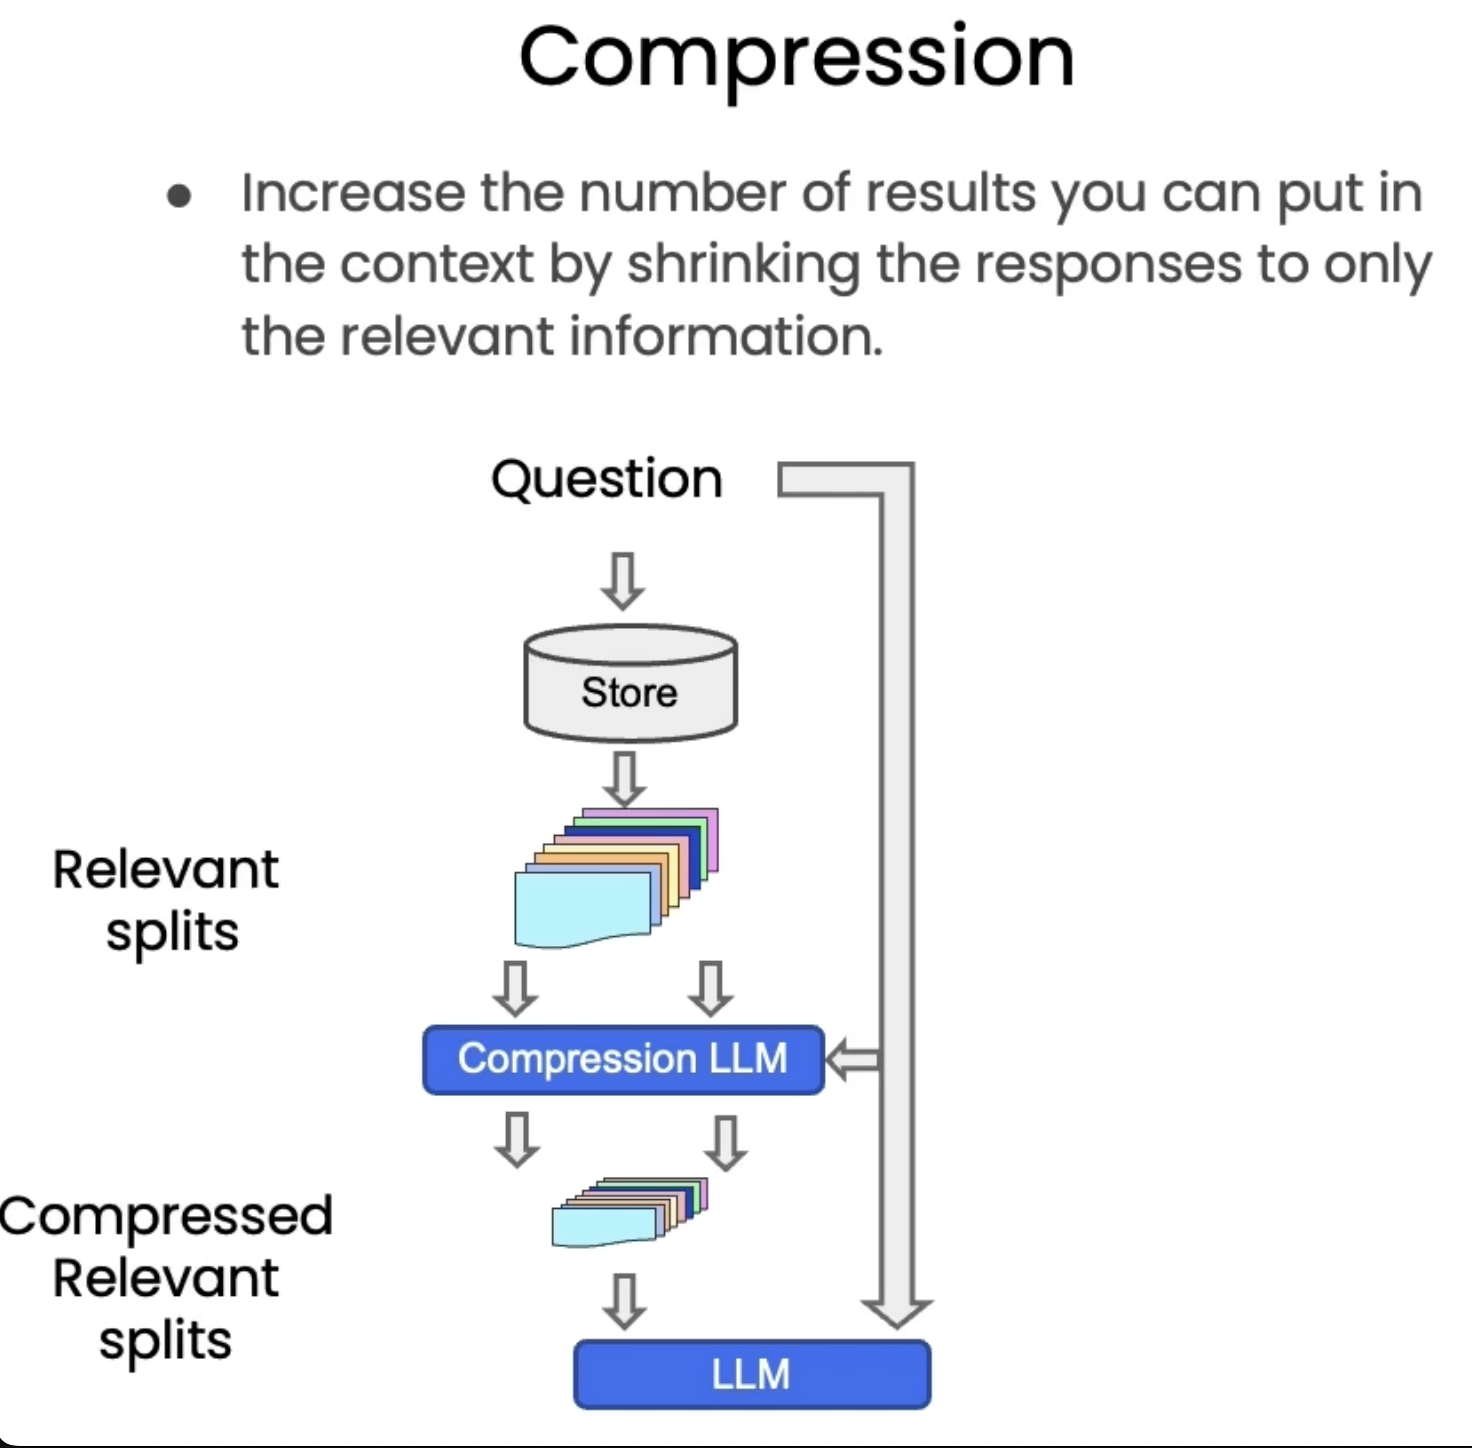

In [1]:
from dotenv import load_dotenv,find_dotenv

_ = load_dotenv(find_dotenv())

### Similarity Seach

In [2]:
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings
persist_directory = 'db/chroma/'

In [3]:
embedding = OpenAIEmbeddings()
vectordb = Chroma(
    persist_directory=persist_directory,
    embedding_function=embedding
)

In [4]:
vectordb._collection.count()

209

In [6]:
# MMR example 

texts = [
    """The Amanita phalloides has a large and imposing epigeous (aboveground) fruiting body (basidiocarp).""",
    """A mushroom with a large fruiting body is the Amanita phalloides. Some varieties are all-white.""",
    """A. phalloides, a.k.a Death Cap, is one of the most poisonous of all known mushrooms.""",
]

In [7]:
smalldb = Chroma.from_texts(texts, embedding=embedding)

In [8]:
question = "Tell me about all-white mushrooms with large fruiting bodies"

In [10]:
smalldb.similarity_search(question, k=2) # no mention of fact of being poisonous

[Document(page_content='A mushroom with a large fruiting body is the Amanita phalloides. Some varieties are all-white.', metadata={}),
 Document(page_content='The Amanita phalloides has a large and imposing epigeous (aboveground) fruiting body (basidiocarp).', metadata={})]

In [11]:
smalldb.max_marginal_relevance_search(question , k = 2 , fetch_k=3)

[Document(page_content='A mushroom with a large fruiting body is the Amanita phalloides. Some varieties are all-white.', metadata={}),
 Document(page_content='A. phalloides, a.k.a Death Cap, is one of the most poisonous of all known mushrooms.', metadata={})]

### Addressing Diversity: Maximum marginal relevance

In vectors_and_embeddings notebook , a problem was found : how to enforce diversity in the search results.
 
`Maximum marginal relevance` strives to achieve both relevance to the query *and diversity* among the results.

In [12]:
question = "what did they say about matlab?"
docs_ss = vectordb.similarity_search(question,k=3)

In [20]:
docs_ss[0].page_content[:100] == docs_ss[0].page_content[:100] # duplicate texts 

True

In [22]:
docs_mmr = vectordb.max_marginal_relevance_search(question , k=3)

In [24]:
docs_mmr[1].page_content

'algorithm then? So what’s different? How come  I was making all that noise earlier about \nleast squares regression being a bad idea for classification problems and then I did a \nbunch of math and I skipped some steps, but I’m, sort of, claiming at the end they’re \nreally the same learning algorithm?  \nStudent: [Inaudible] constants?  \nInstructor (Andrew Ng) :Say that again.  \nStudent: [Inaudible]  \nInstructor (Andrew Ng) :Oh, right. Okay, cool.'

### Addressing Specificity: working with metadata

In vectors_embeddings notebook, we showed that a question about the third lecture can include results from other lectures as well.

To address this, many vectorstores support operations on `metadata`.

`metadata` provides context for each embedded chunk.

In [31]:
question = "what did they say about regression in the third lecture?"

docs_third = vectordb.similarity_search(
    question,
    k=3,
    filter={"source":"ml_doc3.pdf"} # need to specify the source file
)

In [30]:
for d in docs_third:
    print(d.metadata)

{'page': 0, 'source': 'ml_doc3.pdf'}
{'page': 14, 'source': 'ml_doc3.pdf'}
{'page': 4, 'source': 'ml_doc3.pdf'}


### Addressing Specificity: working with metadata using self-query retriever

But we have an interesting challenge: we often want to infer the metadata from the query itself.

To address this, we can use `SelfQueryRetriever`, which uses an LLM to extract:
 
1. The `query` string to use for vector search
2. A metadata filter to pass in as well

Most vector databases support metadata filters, so this doesn't require any new databases or indexes.

In [5]:
from langchain.chat_models import ChatOpenAI
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.base import AttributeInfo

In [6]:
metadata_field_info = [
    AttributeInfo(
        name="source",
        description="The lecture the chunk is from, should be one of `ml_doc1.pdf`, `ml_doc2.pdf`, or `ml_doc3.pdf`",
        type="string",
    ),
    AttributeInfo(
        name="page",
        description="The page from the lecture",
        type="integer",
    ),
] # this informatio will be passed onto language model

In [7]:
document_content_description = "Lecture notes"
llm = ChatOpenAI(temperature=0)
retriever = SelfQueryRetriever.from_llm( # QueryTransformer require lark
    llm,
    vectordb,
    document_content_description,
    metadata_field_info,
    verbose=True
)

In [8]:
question_self = "what did they say about regression in the third lecture?"

In [9]:
import langchain
langchain.debug  = True

In [11]:
docs_self = retriever.get_relevant_documents(question_self)

/Users/ybsid/Projects/openai_cookbook/openaivenv/lib/python3.11/site-packages/langchain/chains/llm.py:278: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[chain/start] [1:retriever:Retriever > 2:chain:LLMChain] Entering Chain run with input:
{
  "query": "what did they say about regression in the third lecture?"
}
[llm/start] [1:retriever:Retriever > 2:chain:LLMChain > 3:llm:ChatOpenAI] Entering LLM run with input:
{
  "prompts": [
    "Human: Your goal is to structure the user's query to match the request schema provided below.\n\n<< Structured Request Schema >>\nWhen responding use a markdown code snippet with a JSON object formatted in the following schema:\n\n```json\n{\n    \"query\": string \\ text string to compare to document contents\n    \"filter\": string \\ logical condition statement for filtering documents\n}\n```\n\nThe query string should contain only text that is expected to match the contents of documents. Any conditions in the filter should not be mentioned in the query as well.\n\nA logical condition statement is composed of one or more comparison and logical operation statements.\n\nA comparison statement takes the 

In [12]:
for d in docs_self:
    print(d.metadata)

{'page': 14, 'source': 'ml_doc3.pdf'}
{'page': 0, 'source': 'ml_doc3.pdf'}
{'page': 10, 'source': 'ml_doc3.pdf'}
{'page': 10, 'source': 'ml_doc3.pdf'}


### Additional tricks: compression

Another approach for improving the quality of retrieved docs is compression.

Information most relevant to a query may be buried in a document with a lot of irrelevant text. 

Passing that full document through your application can lead to more expensive LLM calls and poorer responses.

Contextual compression is meant to fix this. 

In [18]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor
langchain.debug = False

In [19]:
def pretty_print_docs(docs):
    print(f"\n{'-' * 100}\n".join([f"Document {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]))


In [20]:
# Wrap our vectorstore
compressor = LLMChainExtractor.from_llm(llm)

In [21]:
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=vectordb.as_retriever()
)

In [22]:
question = "what did they say about matlab?"
compressed_docs = compression_retriever.get_relevant_documents(question)
pretty_print_docs(compressed_docs)

/Users/ybsid/Projects/openai_cookbook/openaivenv/lib/python3.11/site-packages/langchain/chains/llm.py:278: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


Document 1:

those homeworks will be done in either MATLA B or in Octave, which is sort of — I 
know some people call it a free ve rsion of MATLAB, which it sort  of is, sort of isn't.  
So I guess for those of you that haven't s een MATLAB before, and I know most of you 
have, MATLAB is I guess part of the programming language that makes it very easy to write codes using matrices, to write code for numerical routines, to move data around, to 
plot data. And it's sort of an extremely easy to  learn tool to use for implementing a lot of 
learning algorithms.  
And in case some of you want to work on your  own home computer or something if you 
don't have a MATLAB license, for the purposes of  this class, there's also — [inaudible] 
write that down [inaudible] MATLAB — there' s also a software package called Octave 
that you can download for free off the Internet. And it has somewhat fewer features than MATLAB, but it's free, and for the purposes of  this class, it will work for just abo

## Combining various techniques


In [23]:
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=vectordb.as_retriever(search_type = "mmr")
)

In [24]:
question = "what did they say about matlab?"
compressed_docs = compression_retriever.get_relevant_documents(question)
pretty_print_docs(compressed_docs)

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo in organization org-Ipkgjb8eV212suWndEgA3XmD on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit https://platform.openai.com/account/billing to add a payment method..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo in organization org-Ipkgjb8eV212suWndEgA3XmD on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit ht

Document 1:

those homeworks will be done in either MATLA B or in Octave, which is sort of — I 
know some people call it a free ve rsion of MATLAB, which it sort  of is, sort of isn't.  
So I guess for those of you that haven't s een MATLAB before, and I know most of you 
have, MATLAB is I guess part of the programming language that makes it very easy to write codes using matrices, to write code for numerical routines, to move data around, to 
plot data. And it's sort of an extremely easy to  learn tool to use for implementing a lot of 
learning algorithms.  
And in case some of you want to work on your  own home computer or something if you 
don't have a MATLAB license, for the purposes of  this class, there's also — [inaudible] 
write that down [inaudible] MATLAB — there' s also a software package called Octave 
that you can download for free off the Internet. And it has somewhat fewer features than MATLAB, but it's free, and for the purposes of  this class, it will work for just abo

## Other types of retrieval

It's worth noting that vectordb as not the only kind of tool to retrieve documents. 

The `LangChain` retriever abstraction includes other ways to retrieve documents, such as TF-IDF or SVM.

In [25]:
from langchain.retrievers import SVMRetriever
from langchain.retrievers import TFIDFRetriever
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [26]:
# Load PDF
loader = PyPDFLoader("ml_doc1.pdf")
pages = loader.load()
all_page_text=[p.page_content for p in pages]
joined_page_text=" ".join(all_page_text)

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 1500,chunk_overlap = 150)
splits = text_splitter.split_text(joined_page_text)


In [ ]:
# Retrieve , both require significant calls to API , so not very suitable
svm_retriever = SVMRetriever.from_texts(splits,embedding)
tfidf_retriever = TFIDFRetriever.from_texts(splits)

In [ ]:
question = "What are major topics for this class?"
docs_svm=svm_retriever.get_relevant_documents(question)
docs_svm[0]

In [ ]:
question = "what did they say about matlab?"
docs_tfidf=tfidf_retriever.get_relevant_documents(question)
docs_tfidf[0]